In [3]:
! pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [4]:
!pip install pypotree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pypotree: filename=pypotree-1.0.5-py3-none-any.whl size=10295700 sha256=30fad606cff397705cb9ebc9ced1c7412de8e4cf2ab6da00cabfb96e8746cac4
  Stored in directory: /root/.cache/pip/wheels/ce/67/36/748f466a48d6dd590e3c24f9e9f95221f72657777e8725de94
Successfully built pypotree


In [1]:
import torch
import numpy as np
from generator import DepthNet
from torchvision import transforms
from PIL import Image
from discriminator import Discriminator
# from torchsummary import summary
import matplotlib.pyplot as plt
import open3d as o3d
import plotly.graph_objects as go
import pypotree 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

torch.Size([1, 3, 375, 1242])
encoder output shape: torch.Size([1, 1024, 6, 20])
decoder output shape: torch.Size([1, 1, 375, 1242])
(375, 1242, 1)


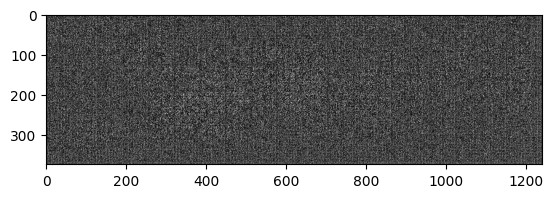

In [2]:
rgb = Image.open("1.png")
rgb_array = np.asarray(rgb, order="C")
transform = transforms.ToTensor()
img = transform(rgb)
img = img[None, :, :, :]
print(img.shape)

model = DepthNet()
depth = model(img)
depth = torch.squeeze(depth, dim=0)
depth = np.transpose(depth.detach().numpy(), (1,2,0))
print(depth.shape)

plt.imshow(depth, cmap="gray");

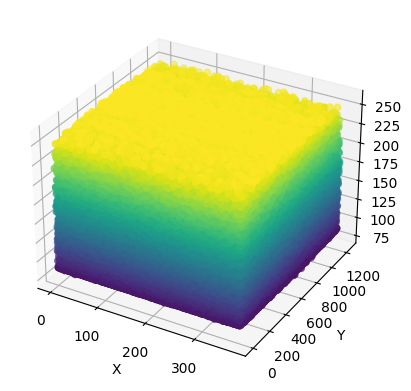

In [151]:
x = np.arange(375)
y = np.arange(1242)
X, Y = np.meshgrid(x, y)
Z = (depth*255).squeeze()  # Remove singleton dimension if present

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c=Z)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [3]:
device = o3d.core.Device("cuda:0")

depth_img = o3d.t.geometry.Image(depth*255)
print(depth_img)
rgb_img = o3d.t.geometry.Image(np.ascontiguousarray(rgb_array).astype(np.float32))
print(rgb_img)
rgbd_img = o3d.t.geometry.RGBDImage(rgb_img, depth_img)
print(rgbd_img)

intrinsics = o3d.core.Tensor([[721.5377, 0, 609.5593],
                              [0, 721.5377, 172.854],
                              [0, 0, 1]])

pcd = o3d.t.geometry.PointCloud.create_from_rgbd_image(
    rgbd_img,
    intrinsics,
    depth_scale=5000.0,
    depth_max=255.0)
print(pcd)

Image[size={375,1242}, channels=1, Float32, CPU:0]
Image[size={375,1242}, channels=3, Float32, CPU:0]
RGBD Image pair [Aligned]
Color [size=(1242,375), channels=3, format=Float32, device=CPU:0]
Depth [size=(1242,375), channels=1, format=Float32, device=CPU:0]
PointCloud on CPU:0 [465750 points (Float32)].
Attributes: colors (dtype = Float32, shape = {465750, 3}).


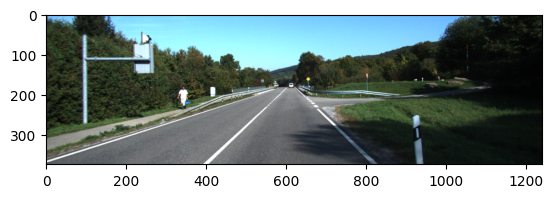

In [4]:
# extrinsics = o3d.core.Tensor([[0.26479293, 0.86222928, 0.43446898, 0.        ],
#                               [0.45140197, 0.34552593, 0.82155755, 0.        ],
#                               [0.85438314, 0.36970814, 0.36639319, 0.        ],
#                               [0.        , 0.        , 0.        , 1.        ]])

extrinsics = o3d.core.Tensor([[1., 0., 0., 0],
                              [0., 1., 0., 0],
                              [0., 0., 1., 0],
                              [0., 0., 0., 1.]])

rgbd_reproj = pcd.project_to_rgbd_image(
    1242,
    375,
    intrinsics,
    extrinsics,
    depth_scale=5000.0,
    depth_max=10.0
)

plt.imshow(np.asarray(rgbd_reproj.color).astype(np.uint8));

In [111]:
print(np.array(rgbd_reproj.color).shape)

(375, 1242, 3)


In [ ]:
|